# Model Building, Results, and Interpretation

Selamat datang di hari keempat pada seri webinar _Conjoint Analysis for Retail Business_.

Sebagai ikhtisar, hari ini kita akan membahas beberapa topik seputar berikut ini:
* model untuk _conjoint analysis_
* part-worth utilities
* willingness-to-pay
* shares prediction

## Model - Under The Hood

```{admonition} Konteks
Pembahasan ini menggunakan pemrograman Python dan pustaka-pustakanya.
```

Mari kita coba lihat sampel data sportscar berikut ini.

```{figure} ../../assets/sample-sportscar-model.png
:name: sample-sportscar-model
Sampel data sportscar dengan 3 alternatif untuk responden 1.
```

Tujuan dari analisis konjoin adalah untuk mengetahui kontribusi dari masing-masing atribut, yang tersedia dengan berbagai level di masing-masing alternatif di setiap set pertanyaan.

Misal kita buat sebuah fungsi untuk setiap masing-masing alternatif tersebut.

```{math}
:label: utility_alternative
\begin{align}
v_1 = alpha \cdot 4 + beta \cdot 100 \\
v_2 = alpha \cdot 5 + beta \cdot 150 \\
v_3 = alpha \cdot 2 + beta \cdot 175 \\
\end{align}
```

Dari {eq}`utility_alternative`, karena kita akan melakukan "estimasi" terhadap utilitas masing-masing alternatif (dan pada akhirnya setiap atribut), kita sediakan sebuah "error" untuk masing-masing fungsi, sehingga diperoleh

```{math}
:label: utility_functions
\begin{align}
u_1 = v_1 + error \\
u_2 = v_2 + error \\
u_3 = v_3 + error \\
\end{align}
```

Persamaan di atas disebut dengan **fungsi utilitas**.

Ingat bahwa kita **tidak bisa mengetahui dengan pasti** nilai utilitas tersebut. Meski begitu, kita **berasumsi** bahwa **responden akan memilih alternatif dengan nilai utilitas paling besar**.

```{math}
:label: choice_max
choice = max([u_1, u_2, u_3])
```

Sehingga, persoalan kita sekarang adalah menentukan probabilitas responden memilih masing-masing dari alternatif tersebut. Untuk alasan penyederhanaan, probabilitas tersebut dapat dikalkulasi dengan persamaan berikut, untuk masing-masing alternatif.

```{math}
:label: prob
\begin{align}
p_1 = \frac{exp(v_1)}{exp(v_1) + exp(v_2) + exp(v_3)} \\
p_2 = \frac{exp(v_2)}{exp(v_1) + exp(v_2) + exp(v_3)} \\
p_3 = \frac{exp(v_3)}{exp(v_1) + exp(v_2) + exp(v_3)} \\
\end{align}
```

Dari {eq}`prob`, kita bisa melihat bahwa probabilitas responden untuk memilih masing-masing alternatif juga **bergantung** dari utilitas dari alternatif yang lain. Hal ini tentu masuk akal, sebagai contoh mungkin kita akan memilih mobil dengan harga yang terbilang mahal jika alternatif yang lain lebih jelek.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from sklearn.preprocessing import OneHotEncoder

## Dataset

Kali ini, kita akan menggunakan data sportscar _long format_.

```{note}
Silakan mengunduh data melalui tautan berikut: [🔗](https://drive.google.com/drive/folders/1rfwS32TI0GnChKLkJamBmzwDDvwbEa-I?usp=sharing
```

In [2]:
df_sportscar = pd.read_csv("../../data/sportscar_choice/sportscar_choice_long.csv")

In [3]:
df_sportscar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   resp_id  6000 non-null   int64 
 1   ques     6000 non-null   int64 
 2   alt      6000 non-null   int64 
 3   segment  6000 non-null   object
 4   seat     6000 non-null   int64 
 5   trans    6000 non-null   object
 6   convert  6000 non-null   object
 7   price    6000 non-null   int64 
 8   choice   6000 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 422.0+ KB


In [4]:
df_sportscar.sample(10, random_state=1)

,resp_id,ques,alt,segment,seat,trans,convert,price,choice
1483,50,5,2,fun,2,manual,yes,40,1
2185,73,9,2,basic,5,auto,yes,35,1
2520,85,1,1,basic,5,manual,no,35,0
3721,125,1,2,racer,5,auto,yes,40,0
3727,125,3,2,racer,5,auto,yes,30,1
4524,151,9,1,basic,4,auto,yes,30,1
234,8,9,1,basic,2,auto,yes,40,0
4735,158,9,2,basic,5,manual,yes,35,0
5839,195,7,2,basic,4,auto,no,30,1
2939,98,10,3,basic,2,auto,no,30,1


In [5]:
def generate_onehot(data, cat_cols=["segment", "trans", "convert"], encoder=None):
    """Generate one-hot data with OneHotEncoder for several columns
    and the compile them with the rest"""
    if not encoder:
        encoder = OneHotEncoder(sparse_output=False)
        onehot_data = encoder.fit_transform(data[cat_cols])
    else:
        onehot_data = encoder.transform(data[cat_cols])
    onehot_data = pd.DataFrame(
        onehot_data,
        columns=encoder.get_feature_names_out()
    )

    data = pd.concat([data, onehot_data], axis=1)
    data.drop(columns=cat_cols, inplace=True)

    return data, encoder

In [6]:
sportscar, encoder = generate_onehot(df_sportscar)

In [7]:
sportscar

,resp_id,ques,alt,seat,price,choice,segment_basic,segment_fun,segment_racer,trans_auto,trans_manual,convert_no,convert_yes
0,1,1,1,2,35,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1,1,2,5,40,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1,1,3,5,30,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1,2,1,5,35,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1,2,2,2,30,1,1.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,200,9,2,2,35,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
5996,200,9,3,4,30,0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
5997,200,10,1,4,40,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
5998,200,10,2,4,30,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## Modeling dengan Python

Tergantung bagaimana bentuk pilihan yang diberikan oleh responden, model yang kita gunakan akan berbeda.

```{table}
:name: response-to-model
:align: center

| type of response | model |
| ------ | ----- |
| rating-based | `OLS` |
| ranking-based | `OLS` / `MNL` |
| choice-based | `MNL` |
```

In [8]:
model = smf.mnlogit("choice ~ trans + convert + seat + price", df_sportscar).fit()

Optimization terminated successfully.
         Current function value: 0.559275
         Iterations 6


Apa yang dilakukan dengan kode di atas?

* `choice ~ trans + convert + seat + price` merupakan persamaan yang menjadi basis dari model **multinomial logit** untuk menentukan masing-masing parameter setiap atribut
* karena atribut `trans`, dan juga `convert` adalah atribut kategoris, secara implisit model akan mengubahnya menjadi matriks _one-hot_ seperti berikut ini.

In [9]:
(dmatrices("choice ~ trans + convert + seat + price", df_sportscar, return_type="dataframe")[1])

,Intercept,trans[T.manual],convert[T.yes],seat,price
0,1.0,1.0,1.0,2.0,35.0
1,1.0,0.0,0.0,5.0,40.0
2,1.0,0.0,0.0,5.0,30.0
3,1.0,1.0,0.0,5.0,35.0
4,1.0,1.0,0.0,2.0,30.0
...,...,...,...,...,...
5995,1.0,0.0,1.0,2.0,35.0
5996,1.0,1.0,0.0,4.0,30.0
5997,1.0,0.0,1.0,4.0,40.0
5998,1.0,0.0,0.0,4.0,30.0


Hasil dari pemodelan di atas adalah sebagai berikut.

In [10]:
print(model.summary())

                          MNLogit Regression Results                          
Dep. Variable:                 choice   No. Observations:                 6000
Model:                        MNLogit   Df Residuals:                     5995
Method:                           MLE   Df Model:                            4
Date:                Thu, 27 Jul 2023   Pseudo R-squ.:                  0.1213
Time:                        14:32:29   Log-Likelihood:                -3355.6
converged:                       True   LL-Null:                       -3819.1
Covariance Type:            nonrobust   LLR p-value:                2.507e-199
       choice=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.2024      0.281     18.542      0.000       4.652       5.752
trans[T.manual]    -1.1155      0.061    -18.356      0.000      -1.235      -0.996
convert[T.yes]      0.1973      

### Interpretasi Parameter

Untuk alasan kesederhanaan dan penjelasan, mari kita buat model sederhana dengan hanya memperhitungkan atribut `seat` dan `price` saja.

In [11]:
simple_model = smf.mnlogit("choice ~ seat + price", df_sportscar).fit()
print(simple_model.summary())

Optimization terminated successfully.
         Current function value: 0.589763
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                 choice   No. Observations:                 6000
Model:                        MNLogit   Df Residuals:                     5997
Method:                           MLE   Df Model:                            2
Date:                Thu, 27 Jul 2023   Pseudo R-squ.:                 0.07345
Time:                        14:32:30   Log-Likelihood:                -3538.6
converged:                       True   LL-Null:                       -3819.1
Covariance Type:            nonrobust   LLR p-value:                1.503e-122
  choice=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4603      0.264     16.871      0.000       3.942       4.979
seat           0.1241      0.

Dari kolom `coef` di atas, untuk kita menginterpretasikan nilai ini, kita gunakan persamaan {eq}`utility_alternative`.

Secara umum, koefisien dari masing-masing atribut tersebut membentuk persamaan:

```{math}
:name: simple-model-interpretation

choice = 0.1241 \cdot seat + -0.1625 \cdot price
```

Variabel **choice** yang dimaksud merujuk pada setiap alternatif yang disajikan. Dengan kata lain, untuk menghitung nilai $v_1$ pada {eq}`utility_alternative`, kita bisa memasukkan nilai `seat` dan `price` pada alternatif $v_1$ tersebut.

Tapi, apa maksud dari nilai-nilai tersebut?

Berdasarkan nilai tersebut, kita bisa membuat interpretasi bahwa:
* nilai positif pada `seat` berarti responden memiliki preferensi lebih ke angka yang besar, alias semakin banyak mobil dapat menampung penumpang, semakin disukai
* sebaliknya, nilai negatif pada `price` berarti responden memiliki preferensi lebih ke mobil dengan harga yang lebih murah

```{hint}
Pada prinsipnya, nilai koefisien yang **lebih dari 1** atau **kurang dari -1** mengindikasikan bahwa atribut tersebut memiliki pengaruh yang "signifikan" terhadap preferensi responden. Sebaliknya, semkain dekat nilai koefisien dengan 0, semakin lemah juga tingkat pengaruh atribut terhadap preferensi responden.
```

Lalu, bagaimana dengan atribut kategoris seperti `convert` atau `trans`? Untuk itu, mari kita lihat pada model sebelumnya.

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 choice   No. Observations:                 6000
Model:                        MNLogit   Df Residuals:                     5995
Method:                           MLE   Df Model:                            4
Date:                Thu, 27 Jul 2023   Pseudo R-squ.:                  0.1213
Time:                        14:32:30   Log-Likelihood:                -3355.6
converged:                       True   LL-Null:                       -3819.1
Covariance Type:            nonrobust   LLR p-value:                2.507e-199
===================================================================================
       choice=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.2024      0.281     18.542      0.000       4.652       5.752
trans[T.manual]    -1.1155      0.061    -18.356      0.000      -1.235      -0.996
convert[T.yes]      0.1973      0.059      3.320      0.001       0.081       0.314
seat                0.1287      0.024      5.356      0.000       0.082       0.176
price              -0.1726      0.008    -22.521      0.000      -0.188      -0.158
===================================================================================
"""

Sebagai _rule of thumb_, untuk atribut yang tidak ditampilkan pada ringkasan di atas, seperti `trans[T.auto]` dan `convert[T.no]`, menandakan bahwa atribut tersebut menjadi basis relatif dari atribut yang ditampilkan. Dengan kata lain, untuk atribut `trans` dan `convert`:
* responden lebih memilih mobil dengan `trans = auto` dibandingkan dengan `manual` karena nilainya yang negatif
* responden lebih memilih mobil dengan `convert = yes` dibandingkan dengan `no`

Selain itu, untuk atribut `seat` dan `price`:
* koefisien negatif dari `price` mengindikasikan bahwa responden lebih memilih mobil dengan harga yang lebih murah
* sedangkan untuk `seat`, kita bisa menganggap bahwa preferensi responden bertambah senilai koefisien untuk setiap tambahan 1 seat

### Willingness to Pay

Dengan menempatkan harga sebagai atribut pada alternatif produk, kita bisa menghitung **willingness to pay** untuk setiap atribut.

```{hint}
{cite:t}`applied_conjoint_analysis` menyebutkan bahwa **willingness to pay (WTP)** merupakan jumlah uang yang rela dibayarkan oleh customer untuk sebuah fitur/atribut tertentu.
```

Untuk menghitung WTP, kita gunakan persamaan berikut.

```{math}
:name: willingness-to-pay

WTP_i = \frac{feat_i}{-feat_{price}}
```

Sehingga, untuk model kita di atas, kita bisa menghitung WTP dengan membagi semua negatif dari koefisien atribut harga.

In [13]:
model.params

,0
Intercept,5.202387
trans[T.manual],-1.115504
convert[T.yes],0.197295
seat,0.128717
price,-0.172622


In [14]:
model.params / -model.params.loc["price"]

,0
Intercept,30.137437
trans[T.manual],-6.462116
convert[T.yes],1.142930
seat,0.745656
price,-1.000000


Dengan mengasumsikan bahwa satuan harga yang digunakan adalah ribuan dolar, WTP untuk masing-masing atribut adalah (selain `price` dan `Intercept`):

* untuk `trans[T.manual]`, responden memiliki preferensi setidaknya untuk memilih mobil dengan transmisi manual, harus ada potongan harga sebesar \$6,462 dari mobil dengan transmisi auto
* untuk `convert[T.yes]`, responden meiliki preferensi bahwa nilai yang harus mereka bayar untuk mendapatkan mobil dengan atap yang dapat dibuka bertambah sebesar \$1,143
* untuk `seat`, responden mengindikasikan bahwa setiap tambahan 1 seat pada mobil, wajar untuk menambah biaya sebesar \$745

### Partworth Utility

**Partworth Utility** adalah sebuah angka yang mengukur seberapa besar masing-masing atribut berpengaruh terhadap keputusan responden untuk memilih alternatif ({cite:t}`applied_conjoint_analysis`.

Kita bisa menggunakan nilai koefisien pada masing-masing atribut sebagai **partworth utility by level** atau nilai utilitas setiap level di atribut. Untuk menghitung **partworth utility by attribute**, kita perlu melakukan beberapa kalkulasi berikut.

In [15]:
conjoint_attributes = ["seat", "trans", "convert", "price"]

In [16]:
levels = []
partworth = []
partworth_range = []

for atr in conjoint_attributes:
    num_levels = df_sportscar[atr].nunique()
    levels.append(df_sportscar[atr].unique().tolist())

    new_part_worth = model.params.loc[model.params.index.str.startswith(atr)].values.tolist()[0]
    new_part_worth.extend([-1 * sum(new_part_worth)])
    partworth_range.append(max(new_part_worth) - min(new_part_worth))
    partworth.append(new_part_worth)


partworth_attribute = []
for part in partworth_range:
    partworth_attribute.append(round(100 * (part / sum(partworth_range)), 2))

In [17]:
print("Part-worth Utility by Attribute:", partworth_attribute)

Part-worth Utility by Attribute: [7.97, 69.11, 12.22, 10.69]


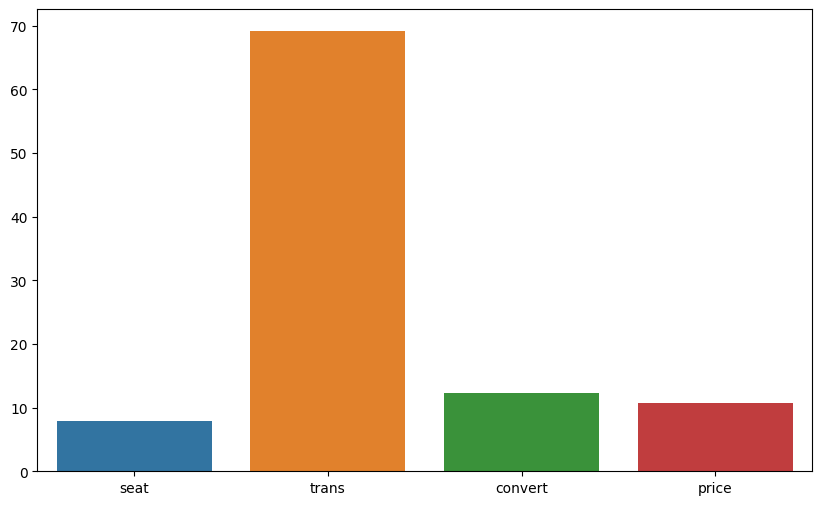

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x=conjoint_attributes, y=partworth_attribute)
plt.show()

Secara umum, berikut adalah langkah-langkah untuk menghitung parworth utlity untuk masing-masing atribut:
1. Hitung **_range_** preferensi dari semua parworth utility level dalam masing-masing atribut, yaitu selisih antara **nilai maksimum** dan **nilai minimum** dari setiap level di suatu atribut.
2. Hitung **_importance ratio_** dari setiap atribut dengan cara membagi **_range_** preferensi suatu atribut dengan **jumlah _range_** keseluruhan atribut

```{hint}
Apa yang bisa kamu simpulkan dari visualisasi part-worth di atas?
```

### Predicting Shares

Untuk menyampaikan hasil analisis ke _business user_ yang mungkin tidak punya latar belakang teknis akan sedikit rumit. Oleh karena itu, kita bisa menggunakan alternatif prediksi tentang apa yang akan orang-orang pilih jika kita hadapkan dengan beberapa alternatif produk.

Misalkan kita ingin membandingkan produk yang mobil yang akan kita luncurkan jika dibandingkan dengan produk kompetitor. Berikut ini adalah fitur-fiturnya.

In [19]:
new_market = pd.DataFrame({
    "seat": [2, 2],
    "trans": ["manual", "auto"],
    "convert": ["no", "no"],
    "price": [35, 30]
})
new_market

,seat,trans,convert,price
0,2,manual,no,35
1,2,auto,no,30


Misalkan saja baris pertama adalah **produk yang akan kita luncurkan** dan baris kedua adalah **produk yang diluncurkan kompetitor**.

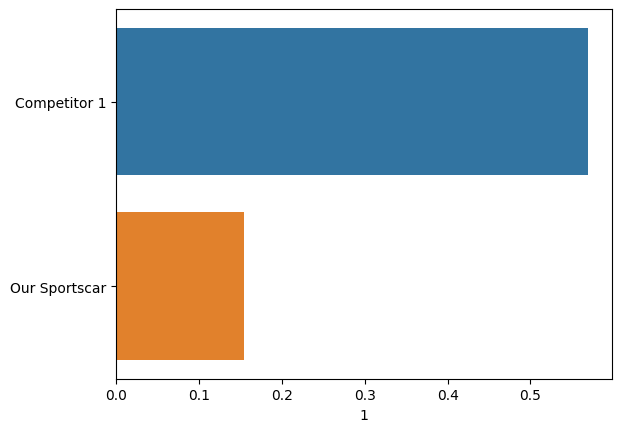

In [20]:
shares = model.predict(new_market)[1]
shares.index = ["Our Sportscar", "Competitor 1"]

sns.barplot(x=shares, y=shares.index, orient="h", order=["Competitor 1", "Our Sportscar"])
plt.show()